# Plot validation between SUNTANS, ROMS and mooring data


In [1]:
# import sys
# sys.path.append('/home/mrayson/group/mrayson/code')
# !export PYTHONPATH="$PYTHONPATH:home/mrayson/code/mycurrents"
!echo $PYTHONPATH

/home/mrayson/code/soda:/home/mrayson/code:/home/mrayson/code/mycurrents:/home/mrayson/code/iwaves:/home/mrayson/code/oceanoi:/home/mrayson/code/mycurrents:/home/mrayson/code/iwaves:/home/mrayson/code/oceanoi::


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
import os
from scipy import signal
from scipy.interpolate import interp1d

import soda.utils.mysignal as sp
from soda.utils.timeseries import timeseries
from soda.dataio.suntans.sunprofile import Profile
from soda.utils.maptools import ll2utm
from soda.utils.modvsobs import ModVsObs
from soda.dataio import netcdfio
import soda.dataio as io
from soda.utils.myproj import MyProj
from soda.dataio.roms.romsio import roms_timeseries, get_depth

#from octant.tools import isoslice
from mycurrents import oceanmooring as om

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'




Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


Warning - could not import octant package.


In [2]:
# %matplotlib notebook

In [3]:
!ls /scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/

# romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/kp150_0.nc'
# ds = xr.open_dataset(romsfile)
# ds

clim_nud.nc		   kp150_2.nc		 obs.nc
corrections.nc		   log			 ocean.in
ecmwf_forcing_2017_1_6.nc  mod.nc		 ocean.in~
error			   nemo_bry_2017_01.nc	 ocean.in_120
fwd_outer0.nc		   nemo_bry_2017_02.nc	 outputs
fwd_outer1.nc		   nemo_bry_2017_03.nc	 outputs_120s
fwd_outer2.nc		   nemo_bry_2017_04.nc	 prelude0.nc
grid.nc			   nemo_bry_2017_05.nc	 prelude1.nc
ini.nc			   nemo_clim_2017_01.nc  prelude2.nc
ini.nc_old		   nemo_clim_2017_02.nc  prelude2.nc.pid3861.ncks.tmp
itftis_0.nc		   nemo_clim_2017_03.nc  README
itftis_1.nc		   nemo_clim_2017_04.nc  romsM_W4DVAR
itftis_2.nc		   nemo_clim_2017_05.nc  s4dvar.in
itl.nc			   nlm_0_sst_end.nc	 stations.in
job.sh			   nlm_1_sst_end.nc	 std_b.nc
job.sh~			   nlm_2_sst_end.nc	 std_f.nc
job_test.sh		   nrm_b.nc		 std_i.nc
job_test.sh~		   nrm_f.nc		 std_m.nc
kp150_0.nc		   nrm_i.nc		 tide_20170101.nc
kp150_1.nc		   nrm_m.nc		 varinfo.dat


In [4]:
def get_suntans_mo(X,Y, Uobs, tobs, zobs, sunTS, sunvar, units):
    """
    Get the suntans evuivalent points
    """
    Umod_xray = sunTS(X, Y, zobs, sunvar, zinterp='nearest')
    # Convert SUNTANS timeseries to an ocean mooring object
    Umod = om.OceanMooring(Umod_xray.time.values, Umod_xray.values.squeeze(),\
        zobs, zinterp='linear')

    return ModVsObs(Umod.t, Umod.y, tobs, Uobs, \
            Z=zobs, units=units, varname=sunvar), Umod

def get_suntans_mo_temp(X,Y, Uobs, sunTS, sunvar, units):
    """
    Get the suntans evuivalent points
    """
    zobs = Uobs.zvar.mean(axis=1)
    Umod_xray = sunTS(X, Y, zobs, sunvar, zinterp='nearest')
    # Convert SUNTANS timeseries to an ocean mooring object
    Umod = om.OceanMooring(Umod_xray.time.values, Umod_xray.values.squeeze(),\
        zobs, zinterp='linear')

    return ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
            Z=zobs, units=units, varname=sunvar), Umod

def get_comparison(lonstation, latstation, P, scenario, uv_ds ):
    # Load the suntans profile
    #sunfile = '../SCENARIOS/TEST_{}/ROMS_SUNTANS_{}_Profile.nc'.format(scenario, scenario)
    sunfile = '../SCENARIOS/TEST_{}/ROMS_SUNTANS_{}_Profile.nc'.format(scenario, scenario)

    sunts = Profile(sunfile)

    # Set the project
    #P = MyProj(None, utmzone=51, isnorth=False)
    # lonstation = uv_ds.X
    # latstation = uv_ds.Y
    xstation, ystation = P.to_xy(lonstation,latstation)


    #print 'Grabbing suntans points...'
    mo_u, Umod = get_suntans_mo(xstation, ystation, uv_ds.u.values, \
                    uv_ds.time.values, np.array([uv_ds.Z]), sunts, 'uc', 'm/s', )

    mo_v, Vmod = get_suntans_mo(xstation, ystation, uv_ds.v.values, \
                    uv_ds.time.values, np.array([uv_ds.Z]), sunts, 'vc', 'm/s')
    
    return mo_u, mo_v, Umod, Vmod

In [31]:
def compare_imos_suntans_temp(sunfile, Tfile, stationT, P, icdatastr, t1,t2, mo_T=None, plot=True):
    print(72*'#')
    print('#\t Station: %s'%stationT)
    #print 'Loading the suntans profile...'
    if mo_T is None:
        sunTS = Profile(sunfile)
        sunTS
        ##########
        # Load the 400 and 200 m velocity and temperature data
        ##########
        #print 'Loading mooring data...'

        Tobs = om.from_netcdf(Tfile, 'temperature', group=stationT).clip(t1,t2)
        #Tobs.X, Tobs.Y

        # Set the project
        #     P = MyProj('merc')
        xstation, ystation = P.to_xy(Tobs.X,Tobs.Y)
        #xstation, ystation

        #print 'Grabbing suntans points...'
        mo_T, Umod = get_suntans_mo_temp(xstation, ystation, Tobs, sunTS, 'temp', 'degC')
    
    if plot:
        mo_T.printStatsZ()

        # Filter and  Convert to oceanmooring objects
        #dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.filt_uneven(34*3600.,order=3), -mo_T.TSobs.Z, positive='down')
        #dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.filt_uneven(34*3600.,order=3), -mo_T.TSmod.Z, positive='down')
        dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.y, -mo_T.TSobs.Z, positive='up')
        dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.y, -mo_T.TSmod.Z, positive='up')
        ####
        # Plot
        plt.figure(figsize=(8,9))
        ax1=plt.subplot2grid((3,3),(0,0),colspan=3)
        dsobs.contourf(np.arange(7,32,1))
        dsobs.contourf(np.arange(7,32,1), filled=False, cbar=False)

        plt.ylabel('Depth')
        ax1.set_xticklabels([])
        
        plt.title(stationT)


        ax2=plt.subplot2grid((3,3),(1,0),colspan=3)
        dsmod.contourf(np.arange(7,32,1))
        dsmod.contourf(np.arange(7,32,1), filled=False, cbar=False)

        plt.ylabel('Depth [m]')
        
        plt.title('%s'%icdatastr)

        # Mean temp
        ax3=plt.subplot2grid((3,3),(2,0),colspan=1)
        plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
        plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
        plt.xlabel('Temperature [$^{\circ}$C]')
        plt.ylabel('Depth [m]')
        plt.grid(b=True)
        plt.xlim([7,30])
        plt.legend(('Mod.','Obs.'), loc='upper left')

        # Bias
        ax4=plt.subplot2grid((3,3),(2,1),colspan=1)
        plt.plot(mo_T.bias, -mo_T.Z,'ko')
        plt.xlim(-3.25,3.25)
        ax4.set_xticks([-2,-1,0,1,2])
        ax4.set_yticklabels([])
        plt.xlabel('Bias [$^{\circ}$C]')
        plt.grid(b=True)


        # RMSE
        ax5=plt.subplot2grid((3,3),(2,2),colspan=1)
        plt.plot(mo_T.rmse, -mo_T.Z,'ko')
        plt.xlim(-3,3)
        ax5.set_yticklabels([])
        plt.xlabel('RMSE [$^{\circ}$C]')
        plt.grid(b=True)

        plt.tight_layout()
        
        #plt.savefig('../FIGURES/IMOS_v_SUNTANS_%s_%s.png'%(icdatastr,stationT), dpi=150)
        plt.show()
    
    return mo_T

In [28]:
# IMOS station file
Tfile = '../DATA/KP150_Gridded_TP.nc'

# Add the site location
P = MyProj(None, utmzone=51,isnorth=False)

lon_prelude, lat_prelude = P.to_ll(534322.7, 8475878.4)

sites = pd.DataFrame(np.array([[lon_prelude, 123.3535, 123.2803, 123.346383,127.56335],\
            [lat_prelude, -13.7621, -13.8170, -13.75895, -9.8122]]).T,
            index=['Prelude','NP250','DWR','KP150_phs2','ITFTIS'], columns=['lon','lat'])

# Load the u/v data as an xarray Dataset
# uv_ds = xr.open_dataset(uvfile)
# print(uv_ds, sites)

In [35]:
# Load a ROMS timeseries object

#tsroms = roms_timeseries(romfile, xyin, varname='ueastward')
def get_roms_station(romsfile, romsvar, xyin, zin):
    dsroms = xr.open_dataset(romsfile)
    #print(dsroms)
    zroms = get_depth(dsroms.s_rho.values, dsroms.Cs_r.values, dsroms.hc.values, dsroms.h.values)# , \
    #         Vtransform=dsroms.Vtransform.values)
    xroms = dsroms.lon_rho.values
    yroms = dsroms.lat_rho.values

    # Get the point
    #dist = np.abs( (xyin[0]-xroms) + 1j*(xyin[1]-yroms))
    #idx = np.argwhere(dist==dist.min())[0,0]
    #xyin, xroms[idx], yroms[idx], zroms[:,idx]

    data = dsroms[romsvar][:]
    #print(zroms[None,...].shape, data.shape)
    #print(zroms.ravel())

    Fi = interp1d(zroms[None,...].squeeze(), data.squeeze(), axis=1)
    
    return om.OceanMooring(dsroms.ocean_time.values, Fi(zin), zin)

def get_roms_mo(X,Y, Uobs, tobs, zobs, romsfile, sunvar, units):
    """
    Get the suntans evuivalent points
    """
    Umod=get_roms_station(romsfile, sunvar, [X,Y], zobs)

    return ModVsObs(Umod.t, Umod.y, tobs, Uobs, \
            Z=zobs, units=units, varname=sunvar), Umod



(1, 30, 1, 1) (49, 30, 1, 1)
[-254.95869412 -241.73493543 -227.6617814  -213.17634503 -198.68834155
 -184.53529732 -170.96364738 -158.12941584 -146.11054832 -134.92416319
 -124.54415653 -114.91664803 -105.97226524  -97.63519202  -89.82938066
  -82.48250016  -75.52819695  -68.90716784  -62.56744257  -56.46417332
  -50.55914301  -44.82013726  -39.22027473  -33.73735491  -28.35325786
  -23.05341421  -17.82635363  -12.66333357   -7.55804726   -2.50640816]
########################################################################
#	 Station: KP150_phs2_T
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 250.5 [m] | 14.319 | 13.275 |  0.226 |  0.298 |  1.064 |  0.354 | -12.326 | 
| 227.8 [m] | 15.421 | 14.972 |  0.207 |  0.152 |  0.520 | -0.261 | -11.179 | 
| 203.6 [m] | 16.769 | 15.723 |  0.358 |  0.254 |  1.114 | -0.283 | -19.091 | 
| 179.4 [m] | 18.459 | 16.568 |  0.502 |  0.455 |

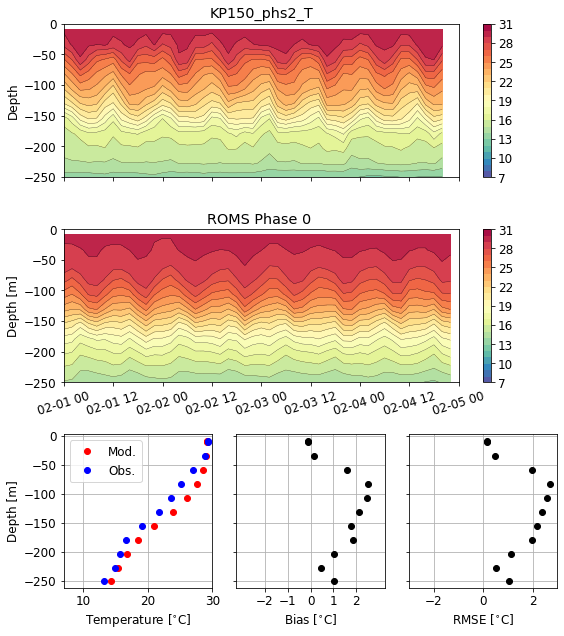

In [33]:

romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/kp150_0.nc'

t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
stationT = 'KP150_phs2_T'
Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
Tobs = Tobsraw.resample(2*3600,ndt=1)

zobs = Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['KP150_phs2'], sites['lat']['KP150_phs2']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 0 ', t1,t2, mo_T=mo_T, plot=True)

# plt.savefig('../FIGURES/temp_comparison_{}_ROMS.png'.format(stationT),dpi=150)


########################################################################
#	 Station: KP150_phs2_T
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 250.5 [m] | 14.336 | 13.275 |  0.232 |  0.298 |  1.083 |  0.290 | -12.824 | 
| 227.8 [m] | 15.429 | 14.972 |  0.212 |  0.152 |  0.528 | -0.262 | -11.551 | 
| 203.6 [m] | 16.776 | 15.723 |  0.367 |  0.254 |  1.123 | -0.278 | -19.425 | 
| 179.4 [m] | 18.467 | 16.568 |  0.503 |  0.455 |  1.976 | -0.092 | -18.679 | 
| 155.2 [m] | 20.921 | 19.141 |  0.676 |  1.165 |  2.185 |  0.012 | -2.664 | 
| 131.0 [m] | 23.877 | 21.735 |  0.780 |  1.076 |  2.393 |  0.203 | -4.160 | 
| 106.8 [m] | 26.149 | 23.621 |  0.743 |  0.907 |  2.643 |  0.310 | -7.851 | 
| 82.6 [m] | 27.717 | 25.096 |  0.631 |  0.860 |  2.761 |  0.029 | -9.736 | 
| 58.4 [m] | 28.715 | 27.005 |  0.272 |  1.167 |  2.063 | -0.136 | -2.254 | 
| 34.2 [m] | 29.120 | 28.857 |  0.119 

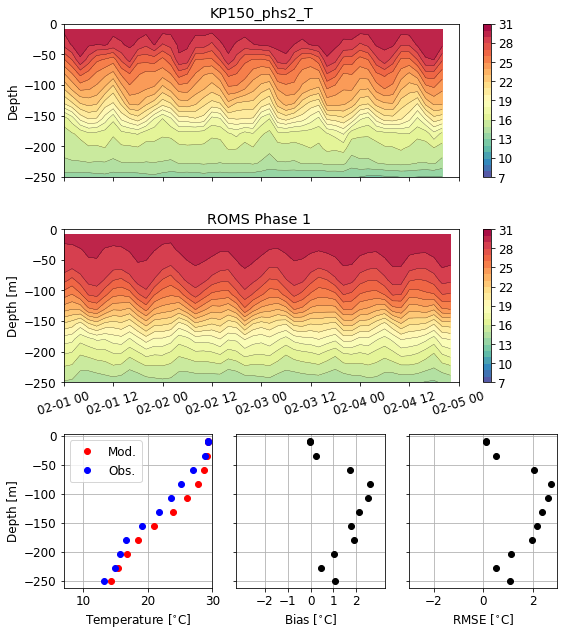

In [36]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/kp150_1.nc'

t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
stationT = 'KP150_phs2_T'
Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
Tobs = Tobsraw.resample(2*3600,ndt=1)

zobs = Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['KP150_phs2'], sites['lat']['KP150_phs2']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 1 ', t1,t2, mo_T=mo_T, plot=True)

# plt.savefig('../FIGURES/temp_comparison_{}_ROMS.png'.format(stationT),dpi=150)


########################################################################
#	 Station: KP150_phs2_T
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 250.5 [m] | 14.327 | 13.275 |  0.236 |  0.298 |  1.075 |  0.313 | -12.623 | 
| 227.8 [m] | 15.428 | 14.972 |  0.209 |  0.152 |  0.528 | -0.293 | -11.555 | 
| 203.6 [m] | 16.777 | 15.723 |  0.361 |  0.254 |  1.120 | -0.250 | -19.293 | 
| 179.4 [m] | 18.470 | 16.568 |  0.493 |  0.455 |  1.973 | -0.055 | -18.616 | 
| 155.2 [m] | 20.932 | 19.141 |  0.669 |  1.165 |  2.180 |  0.055 | -2.647 | 
| 131.0 [m] | 23.895 | 21.735 |  0.779 |  1.076 |  2.402 |  0.241 | -4.199 | 
| 106.8 [m] | 26.189 | 23.621 |  0.756 |  0.907 |  2.675 |  0.351 | -8.068 | 
| 82.6 [m] | 27.801 | 25.096 |  0.645 |  0.860 |  2.827 |  0.099 | -10.257 | 
| 58.4 [m] | 28.824 | 27.005 |  0.265 |  1.167 |  2.139 | -0.074 | -2.499 | 
| 34.2 [m] | 29.236 | 28.857 |  0.179

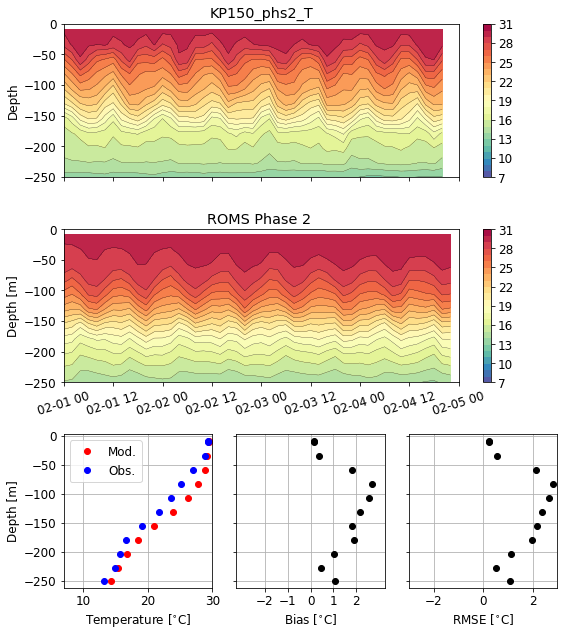

In [37]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/kp150_2.nc'

t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
stationT = 'KP150_phs2_T'
Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
Tobs = Tobsraw.resample(2*3600,ndt=1)

zobs = Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['KP150_phs2'], sites['lat']['KP150_phs2']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 2 ', t1,t2, mo_T=mo_T, plot=True)


In [21]:
!ncdump -h ../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc

netcdf IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s {
dimensions:
	TIME = 291157 ;
	NOMINAL_DEPTH = 18 ;
variables:
	double LATITUDE ;
		LATITUDE:_FillValue = NaN ;
		LATITUDE:axis = "Y" ;
		LATITUDE:long_name = "latitude" ;
		LATITUDE:reference_datum = "WGS84 geographic coordinate system" ;
		LATITUDE:standard_name = "latitude" ;
		LATITUDE:units = "degrees_north" ;
		LATITUDE:valid_max = 90. ;
		LATITUDE:valid_min = -90. ;
	double LONGITUDE ;
		LONGITUDE:_FillValue = NaN ;
		LONGITUDE:axis = "X" ;
		LONGITUDE:long_name = "longitude" ;
		LONGITUDE:reference_datum = "WGS84 geographic coordinate system" ;
		LONGITUDE:standard_name = "longitude" ;
		LONGITUDE:units = "degrees_east" ;
		LONGITUDE:valid_max = 180. ;
		LONGITUDE:valid_min = -180. ;
	int64 TIME(TIME) ;
		TIME:units = "minutes since 2016-07-27 00:00:00" ;
		TIME:calendar = "proleptic_gregorian" ;
	double NOMINAL_DEPTH(NOMINAL_DEPTH) ;
		NOMINAL_DEPTH:_FillValue = NaN ;
		NOMINAL_DEPTH:axis = "Z" ;
		NOMINAL_DEPTH:long_name = "no

In [39]:
# Load the TIMOR sea data
Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc'
t1,t2 = datetime(2017,2,1), datetime(2017,2,5)

dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso.TIME.values, dso.TEMP.values, dso.NOMINAL_DEPTH.values).clip(t1,t2)
#Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
Tobs = Tobsraw.resample(2*3600,ndt=1)

########################################################################
#	 Station: ITFTIS
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 16.5 [m] | 29.958 | 28.797 |  0.112 |  1.156 |  1.623 | -0.074 | -1.056 | 
| 26.0 [m] | 29.904 | 28.329 |  0.107 |  1.431 |  2.097 | -0.021 | -1.237 | 
| 36.0 [m] | 29.824 | 27.780 |  0.112 |  1.711 |  2.624 | -0.060 | -1.452 | 
| 46.0 [m] | 29.719 | 27.115 |  0.141 |  1.844 |  3.137 | -0.060 | -2.019 | 
| 56.0 [m] | 29.490 | 26.304 |  0.301 |  1.846 |  3.617 | -0.005 | -3.002 | 
| 66.0 [m] | 29.040 | 25.428 |  0.542 |  1.727 |  3.922 |  0.089 | -4.380 | 
| 76.0 [m] | 28.423 | 24.629 |  0.782 |  1.676 |  4.066 |  0.130 | -5.135 | 
| 96.0 [m] | 26.663 | 23.164 |  1.072 |  1.828 |  3.904 |  0.149 | -3.754 | 
| 111.0 [m] | 25.124 | 22.051 |  1.236 |  2.046 |  3.742 |  0.092 | -2.487 | 
| 126.0 [m] | 23.572 | 20.638 |  1.465 |  2.225 |  3.9

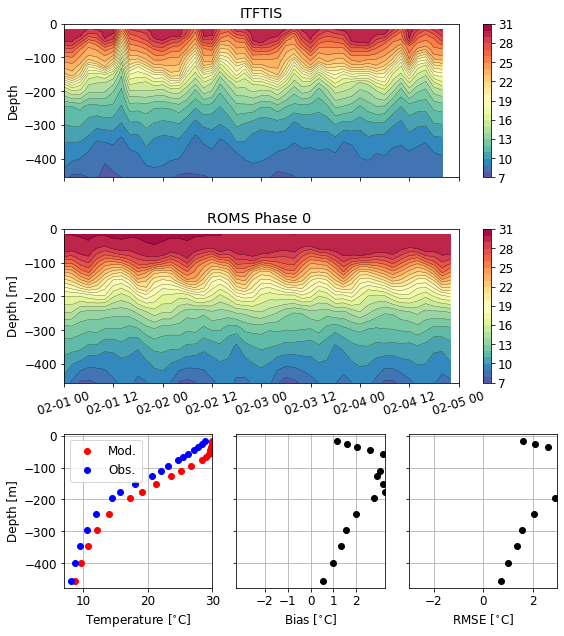

In [40]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/itftis_0.nc'

# t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
# stationT = 'KP150_phs2_T'
# Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
# Tobs = Tobsraw.resample(2*3600,ndt=1)

stationT = 'ITFTIS'

zobs = -Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['ITFTIS'], sites['lat']['ITFTIS']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 0 ', t1,t2, mo_T=mo_T, plot=True)


########################################################################
#	 Station: ITFTIS
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 16.5 [m] | 30.128 | 28.797 |  0.061 |  1.156 |  1.736 | -0.084 | -1.351 | 
| 26.0 [m] | 30.075 | 28.329 |  0.073 |  1.431 |  2.217 | -0.020 | -1.501 | 
| 36.0 [m] | 29.986 | 27.780 |  0.119 |  1.711 |  2.743 | -0.070 | -1.679 | 
| 46.0 [m] | 29.871 | 27.115 |  0.169 |  1.844 |  3.255 | -0.060 | -2.249 | 
| 56.0 [m] | 29.645 | 26.304 |  0.332 |  1.846 |  3.748 | -0.035 | -3.298 | 
| 66.0 [m] | 29.219 | 25.428 |  0.573 |  1.727 |  4.082 |  0.053 | -4.827 | 
| 76.0 [m] | 28.624 | 24.629 |  0.818 |  1.676 |  4.252 |  0.100 | -5.709 | 
| 96.0 [m] | 26.850 | 23.164 |  1.105 |  1.828 |  4.081 |  0.136 | -4.196 | 
| 111.0 [m] | 25.248 | 22.051 |  1.279 |  2.046 |  3.865 |  0.075 | -2.721 | 
| 126.0 [m] | 23.639 | 20.638 |  1.532 |  2.225 |  3.9

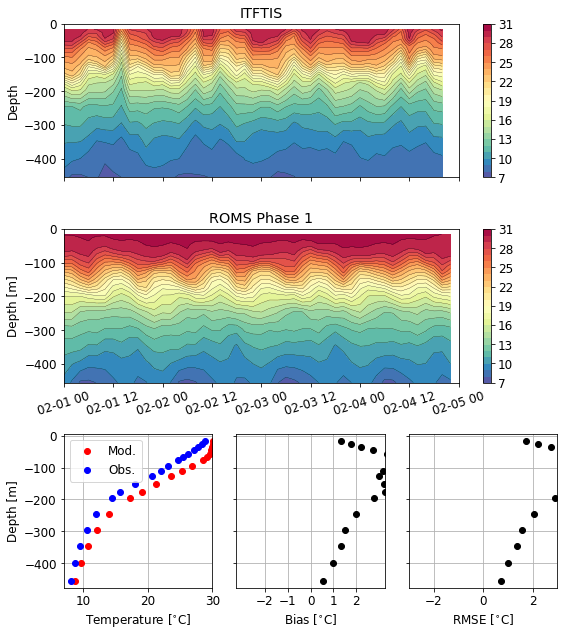

In [41]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/itftis_1.nc'

# t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
# stationT = 'KP150_phs2_T'
# Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
# Tobs = Tobsraw.resample(2*3600,ndt=1)

stationT = 'ITFTIS'

zobs = -Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['ITFTIS'], sites['lat']['ITFTIS']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 1', t1,t2, mo_T=mo_T, plot=True)


########################################################################
#	 Station: ITFTIS
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| 16.5 [m] | 30.092 | 28.797 |  0.070 |  1.156 |  1.711 | -0.072 | -1.286 | 
| 26.0 [m] | 30.041 | 28.329 |  0.077 |  1.431 |  2.193 | -0.010 | -1.448 | 
| 36.0 [m] | 29.956 | 27.780 |  0.119 |  1.711 |  2.721 | -0.053 | -1.636 | 
| 46.0 [m] | 29.839 | 27.115 |  0.172 |  1.844 |  3.232 | -0.060 | -2.204 | 
| 56.0 [m] | 29.614 | 26.304 |  0.339 |  1.846 |  3.726 | -0.037 | -3.246 | 
| 66.0 [m] | 29.192 | 25.428 |  0.573 |  1.727 |  4.062 |  0.051 | -4.768 | 
| 76.0 [m] | 28.597 | 24.629 |  0.819 |  1.676 |  4.229 |  0.100 | -5.636 | 
| 96.0 [m] | 26.817 | 23.164 |  1.113 |  1.828 |  4.051 |  0.134 | -4.120 | 
| 111.0 [m] | 25.209 | 22.051 |  1.284 |  2.046 |  3.835 |  0.077 | -2.662 | 
| 126.0 [m] | 23.598 | 20.638 |  1.530 |  2.225 |  3.9

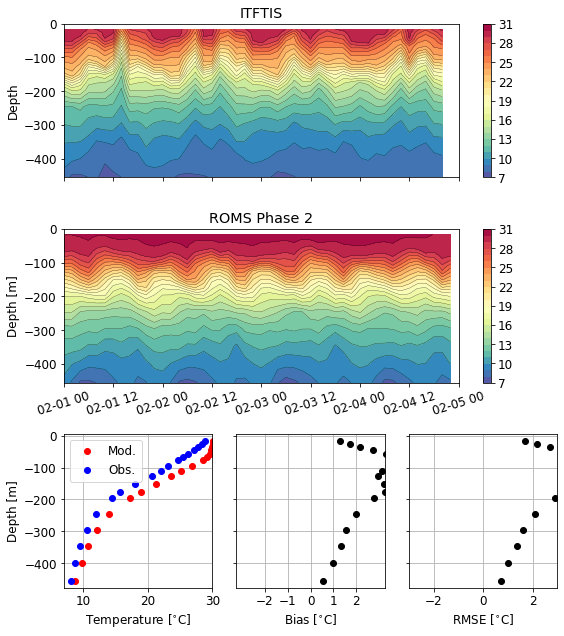

In [43]:
romsfile = '/scratch/pawsey0219/ijanekovic/NWS_ASSIM/CYCLE/itftis_2.nc'

# t1,t2 = datetime(2017,2,1), datetime(2017,2,5)
# stationT = 'KP150_phs2_T'
# Tobsraw = om.from_netcdf(Tfile, 'watertemp', group=stationT).clip(t1,t2)
# Tobs = Tobsraw.resample(2*3600,ndt=1)

stationT = 'ITFTIS'

zobs = -Tobs.Z
#zobs = Tobs.zvar.mean(axis=1)

xyin = np.array([sites['lon']['ITFTIS'], sites['lat']['ITFTIS']])
romsvar = 'temp'
Tmod = get_roms_station(romsfile, romsvar, xyin, zobs )


mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

compare_imos_suntans_temp(None, None, stationT, None, 'ROMS Phase 2', t1,t2, mo_T=mo_T, plot=True)


(<matplotlib.contour.QuadContourSet at 0x2adc03a4ab10>,
 <matplotlib.colorbar.Colorbar at 0x2adc03a77f90>)

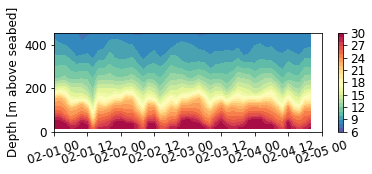

In [27]:
plt.figure()
#plt.subplot(211)
#Tmod.contourf(np.arange(12,31))

plt.subplot(212)
Tobs.contourf(np.arange(6,31))